In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
import os
import numpy as np
import specsim.simulator
from speclite import filters
from speclite import redshift
from astropy.constants import h, c, k_B, sigma_sb
from astropy.cosmology import Planck18
from astropy.table import Table, join
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import bed
from bed.grid import Grid, PermutationInvariant
from bed.design import ExperimentDesigner
from bed.grid import TopHat
import galsim

# local imports
from lsstetc import ETC
from functions import *

In [2]:
# Define the filters
filters_list = ['r', 'i']
num_designs = 10
# Define the number of visits corresponding to each filter
designs = Grid(n_r=np.linspace(5, 50, num_designs), n_i=np.linspace(5, 50, num_designs))
num_features = 101
# Define the magnitudes corresponding to each filter
features = Grid(mag_r=np.linspace(30.0, 20.0, num_features), mag_i=np.linspace(30.0, 20.0, num_features))
num_parameters = 102
# Define the redshift values
parameters = Grid(z=np.linspace(0.1, 1.0, num_parameters))

In [3]:
def unnorm_lfunc(parameters, features, designs, **kwargs):
    
    filters = kwargs['filters_list']
    diff_terms = []

    gal = galsim.Gaussian(flux=1.0, sigma=2) # sigma = 2 arcsec
    psf = galsim.Gaussian(fwhm=0.67) # Full-width half-max of the PSF in arcseconds
    profile = galsim.Convolve([gal, psf])

    for f in filters:
        # initialize the ETC for each filter
        etc = ETC(band=f, profile=profile, pixel_scale=0.2, stamp_size=31, threshold=0.0, visit_time=30.0)

        # get the observed magnitudes
        mag_obs = getattr(features, f"mag_{f}")

        # get the model magnitudes
        mags_model = M_b(parameters.z, f)
    
        # get the number of visits
        nvisits = getattr(designs, f"n_{f}")

        # get the sigma associated with each number of visits
        sigma = etc.mag_err(mags_model, nvisits)

        # get the difference to calculate the likelihood
        diff = (mag_obs - mags_model) / sigma
        diff_terms.append(diff)

    broadcast_shape = np.broadcast(*diff_terms).shape
    likelihood = np.ones(broadcast_shape)

    for diff in diff_terms:
        likelihood *= np.exp(-0.5 * diff**2)

    print("Likelihood shape:", likelihood.shape)

    return likelihood

In [4]:
prior = TopHat(parameters.z)

In [5]:
designer = ExperimentDesigner(parameters, features, designs, unnorm_lfunc, lfunc_args={"filters_list": filters_list})

In [6]:
designer = ExperimentDesigner(parameters, features, designs, unnorm_lfunc, lfunc_args={"filters_list": filters_list})
best = designer.calculateEIG(prior)
designer.describe()

Likelihood shape: (101, 101, 100, 1, 102)
Likelihood shape: (101, 101, 100, 1, 102)
GRID           designs [10:n_r, 10:n_i]
GRID          features [101:mag_r, 101:mag_i]
GRID        parameters [102:z]
ARRAY            prior (102,)                           0.0 Mb
ARRAY       likelihood (101, 101, 100, 1, 102)        793.8 Mb
ARRAY         marginal (101, 101, 100, 1)               7.8 Mb
ARRAY               IG (101, 101, 100, 1)               7.8 Mb
ARRAY              EIG (10, 10)                         0.0 Mb


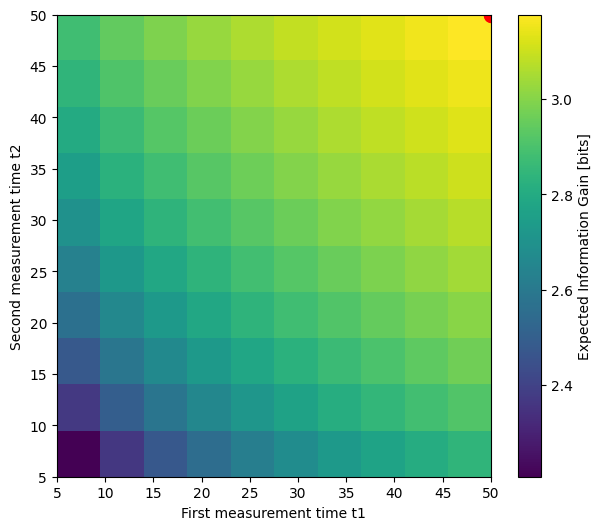

In [8]:
fig, ax = plt.subplots(figsize=(7,6))
I = ax.imshow(designer.EIG.T, origin='lower', extent=designs.extent('n_r')+designs.extent('n_i'), aspect='auto')
plt.colorbar(I, ax=ax, label='Expected Information Gain [bits]')
ax.plot([best['n_r'], best['n_i']], [best['n_i'], best['n_r']], 'ro', markersize=10)
ax.set(xlabel='First measurement time t1', ylabel='Second measurement time t2');

Let's add a constraint to the number of visits across the bands by restricting it to 50 total visits.

In [9]:
num_designs = 100
# Define the number of visits corresponding to each filter
designs = Grid(n_r=np.linspace(5, 50, num_designs), n_i=np.linspace(5, 50, num_designs), constraint= lambda n_r, n_i: n_r + n_i == 50)

In [10]:
designer = ExperimentDesigner(parameters, features, designs, unnorm_lfunc, lfunc_args={"filters_list": filters_list})

In [11]:
designer = ExperimentDesigner(parameters, features, designs, unnorm_lfunc, lfunc_args={"filters_list": filters_list})
best = designer.calculateEIG(prior)
designer.describe()

Likelihood shape: (101, 101, 85, 1, 102)
Likelihood shape: (101, 101, 85, 1, 102)
GRID           designs [85:n_r, 85:n_i]
GRID          features [101:mag_r, 101:mag_i]
GRID        parameters [102:z]
ARRAY            prior (102,)                           0.0 Mb
ARRAY       likelihood (101, 101, 85, 1, 102)         674.8 Mb
ARRAY         marginal (101, 101, 85, 1)                6.6 Mb
ARRAY               IG (101, 101, 85, 1)                6.6 Mb
ARRAY              EIG (85, 1)                          0.0 Mb


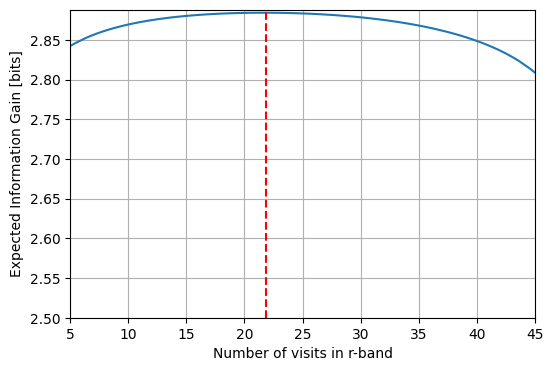

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(designs.n_r, designer.EIG)
ax.set(xlabel='Number of visits in r-band', xlim=designs.extent('n_r'),
       ylabel='Expected Information Gain [bits]', ylim=(2.5, None))
ax.axvline(best['n_r'], color='r', linestyle='--')
ax.grid();